In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
import math

In [2]:
# Rotational matrix

def s(angle, rad = True):
    if rad == False:
        angle = math.radians(angle)
    return math.sin(angle)

def c(angle, rad = True):
    if rad == False:
        angle = math.radians(angle)
    return math.cos(angle)

def Rotation_BA(alpha, beta, gamma, rad = True):
    if rad == False:
        a, b, y = math.radians(alpha), math.radians(beta), math.radians(gamma)
    else:
        a, b, y = alpha, beta, gamma
    row1 = np.array([c(y)*c(b), c(y)*s(b)*s(a) - s(y)*c(a), c(y)*s(b)*c(a) + s(y)*s(a)])
    row2 = np.array([s(y)*c(b), s(y)*s(b)*s(a) + c(y)*c(a), s(y)*s(b)*c(a) - c(y)*s(a)])
    row3 = np.array([-s(b), c(b)*s(a), c(b)*c(a)])
    result = np.concatenate([row1, row2, row3]).reshape(3,3)
    return result

def Rotation(angle, direction, rad = True):
    if rad == False:
        angle = math.radians(angle)
    
    if direction == 'x':
        R = np.array([[1, 0, 0],
                      [0, c(angle), -s(angle)],
                      [0, s(angle), c(angle)]])
    elif direction == 'y':
        R = np.array([[c(angle), 0, s(angle)],
                      [0, 1, 0],
                      [-s(angle), 0, c(angle)]])
    elif direction == 'z':
        R = np.array([[c(angle), -s(angle), 0],
                      [s(angle), c(angle), 0],
                      [0, 0, 1]])
    return R

def Rotation_non_pincipal_axes(angle, direction, rad = True):
    if rad == False:
        a = math.radians(angle)
    else:
        a = angle
    
    # Convert the direction to unit vector, if the direction is already unit vector, norm = 1
    [ux, uy, uz] = direction/np.linalg.norm(direction)
    
    # Use equation 33
    row1 = np.array([ux*ux*(1-c(a))+c(a), ux*uy*(1-c(a))-uz*s(a), ux*uz*(1-c(a))+uy*s(a)]).reshape(1, -1)
    row2 = np.array([ux*uy*(1-c(a))+uz*s(a), uy*uy*(1-c(a))+c(a), uy*uz*(1-c(a))-ux*s(a)]).reshape(1, -1)
    row3 = np.array([ux*uz*(1-c(a))-uy*s(a), uy*uz*(1-c(a))+ux*s(a), uz*uz*(1-c(a))+c(a)]).reshape(1, -1)
    result = np.concatenate([row1, row2, row3], axis = 0)
    
    return result
        

def Transformation(rotation, translation):
    '''
    Transform from frame B to frame A
    rotation: rotation of B relative to A
    translation or B0: Position of origin of frame B with respect to A
    
    '''
    # Translation from B to A
    
    if np.shape(rotation)!= (3,3):
        print('Wrong rotation matrix')
        return None
    if np.shape(translation)!= (3,1):
        print('Wrong translation matrix')
        return None
    T = np.concatenate([rotation, translation], axis = 1)
    add_row = np.array([0,0,0,1]).reshape(1,-1)
    T = np.concatenate([T, add_row], axis = 0)
    return T
  
def Mapping(transformation, coordinate):
    '''
    Map a point through a transformation matrix
    '''
    if np.shape(transformation)!= (4,4):
        print('Wrong transformation matrix')
        return None
    if np.shape(coordinate)!= (3,1):
        print('Wrong coordinate matrix')
        return None
    
    coordinate = np.append(coordinate, [[1]], axis = 0)
    
    result = np.matmul(transformation, coordinate)
    
    # need to ignore the last value in the last row
    return result[:-1]

def Euler_parameters(alpha, A_U, rad = True):
    if rad == False:
        alpha = math.radians(alpha)
    [ux, uy, uz] = A_U
    
    e0 = ux*s(alpha/2)
    e1 = uy*s(alpha/2)
    e2 = uz*s(alpha/2)
    e3 = c(alpha/2)
    
    print(f'Check the summed square: {round(e0**2 + e1**2 + e2**2 + e3**2,2)}')
    return [e0, e1, e2, e3]

def Get_angle_from_rotation(rotation):
    if np.shape(rotation)!= (3,3):
        print('Wrong rotation matrix')
        return None
    [r11, r12, r13, r21, r22, r23, r31, r32, r33] = np.squeeze(rotation.reshape(1,-1))
    
    # Cosine is an even function, thus we expect to have 2 answers, 1 postive and 1 negative 
    alpha1 = np.arccos((r11 + r22 + r33 - 1)/2)
    print(f'Alpha 1 is {alpha1} rad, {np.degrees(alpha1)} degrees')
    
    # A_U is the unit vector of revolution relative to a fixed frame {A}
    A_U_1 = 1/(2*s(alpha1))*np.array([r32-r23, r13-r31, r21-r12])
    print(f'Rotation axis 1 is {A_U_1}')
    
    euler1 = Euler_parameters(alpha1, A_U_1, rad = True)
    print(f'Euler parameter 1 is {euler1}')
    
    print('-----------------------------')
    alpha2 = -alpha1
    print(f'Alpha 2 is {alpha2} rad, {np.degrees(alpha2)} degrees')
    A_U_2 = 1/(2*s(alpha2))*np.array([r32-r23, r13-r31, r21-r12])
    
    print(f'Rotation axis 2 is {A_U_2}')
    euler2 = Euler_parameters(alpha2, A_U_2, rad = True)
    
    print(f'Euler parameter 2 is {euler2}')
    
    return [alpha1, A_U_1, euler1], [alpha2, A_U_2, euler2]

def Tlink(DH):
    # This function calculates the Homogeneous Transformation matrix for a
    # link, receiving as input the DH parameters for the link
    # DH parameters are in the form of an array with: link length, link
    # twist, joint offset, joint angle

    # Set: a:link length; alpha:link twist; d:joint offset; theta:joint
    # angle
    a = DH[0]; alpha = DH[1]; d = DH[2]; theta = DH[3];

    # Set a 4x4 symbolic T matrix 
    T = zeros(4)
    # Line 1
    T[0,0] = cos(theta); T[0,1] = -sin(theta); T[0,2] = 0; T[0,3] = a;
    # Line 2
    T[1,0] = sin(theta)*cos(alpha); T[1,1] = cos(theta)*cos(alpha); 
    T[1,2] = -sin(alpha); T[1,3] = -sin(alpha)*d;
    # Line 3
    T[2,0] = sin(theta)*sin(alpha); T[2,1] = cos(theta)*sin(alpha); 
    T[2,2] = cos(alpha); T[2,3] = cos(alpha)*d;
    # Line 4
    T[3,0] = 0; T[3,1] = 0; T[3,2] = 0; T[3,3] = 1;

    return T

def symprint(symbol, sup, sub, dot=False):
    if dot == 1:
        symbol = r'\dot{%s}' % symbol
    elif dot == 2:
        symbol = r'\ddot{%s}' % symbol
    if sup == '':
        info = r"{}_{}".format(symbol, sub)
    else:
        info = r"^{}{}_{}".format(sup, symbol, sub)
    display(symbols(info))
    
def Position_finder(sym_matrix):
    # exclude the last row and display the last column
    return sym_matrix[:-1,-1]

def revolute_joint(frame, theta_dot, transform_low_high, omega, v, Display = True, Display_all_details = False):

    # Transpose and extract the 3x3 matrix
    rotation_high_low = transform_low_high.T[:3, :3]
    P = transform_low_high[:3, -1]
    # theta_dot = symbols(r'\dot{\theta_{%s}}' % frame)
    if frame != 'e':
        omega_new = simplify(rotation_high_low * omega + theta_dot * Matrix([0, 0, 1]))
    else:
        omega_new = simplify(rotation_high_low * omega)
    v_new = simplify(rotation_high_low * (v + omega.cross(P)))
    
    if Display_all_details:
        print('R')
        display(rotation_high_low)
        print('v_prev')
        display(v)
        print('omega_prev')
        display(omega)
        print('P')
        display(P)
        print('omega x P')
        display(omega.cross(P))
        print('theta_dot * k')
        display(theta_dot * Matrix([0, 0, 1]))
    
    if Display:
        symprint('\Omega', frame, frame)
        display(omega_new)
        symprint('V', frame, frame)
        display(v_new)
    
    return [omega_new, v_new]

def prismatic_joint(frame, d_dot, transform_low_high, omega, v, Display = True, Display_all_details = False):

    # Transpose and extract the 3x3 matrix
    rotation_high_low = transform_low_high.T[:3, :3]
    P = transform_low_high[:3, -1]
    # d_dot = symbols(r'\dot{d_{%s}}' % frame)
    omega_new = simplify(rotation_high_low * omega)
    if frame != 'e':
        v_new  = simplify(rotation_high_low * (v + omega.cross(P)) + d_dot * Matrix([0, 0, 1])) 
    else:
        v_new  = simplify(rotation_high_low * (v + omega.cross(P))) 
    
    if Display_all_details:
        print('R')
        display(rotation_high_low)
        print('v_prev')
        display(v)
        print('omega_prev')
        display(omega)
        print('P')
        display(P)
        print('omega x P')
        display(omega.cross(P))
        print('d_dot * k')
        display(d_dot * Matrix([0, 0, 1]))
    
    if Display:
        symprint('\Omega', frame, frame)
        display(omega_new)
        symprint('V', frame, frame)
        display(v_new)    
    
    return [omega_new, v_new]

def Jacobian(parameters, v_ee, omega_ee, transform_low_high, Display = True, Display_all_details = False):
    
    if len(parameters) == 3:
        a, b, c = parameters
        Jee = Matrix([[v_ee[0].diff(a), v_ee[0].diff(b), v_ee[0].diff(c)],
                      [v_ee[1].diff(a), v_ee[1].diff(b), v_ee[1].diff(c)],
                      [v_ee[2].diff(a), v_ee[2].diff(b), v_ee[2].diff(c)],
                      [omega_ee[0].diff(a), omega_ee[0].diff(b), omega_ee[0].diff(c)],
                      [omega_ee[1].diff(a), omega_ee[1].diff(b), omega_ee[1].diff(c)],
                      [omega_ee[2].diff(a), omega_ee[2].diff(b), omega_ee[2].diff(c)]])
        if Display_all_details:
            display(simplify(Matrix([[transform_low_high[:3, :3], zeros(3)],[zeros(3), transform_low_high[:3, :3]]])))
        J0 = simplify(Matrix([[transform_low_high[:3, :3], zeros(3)],[zeros(3), transform_low_high[:3, :3]]]) * Jee)
        
    elif len(parameters) == 4:
        a, b, c, d = parameters
        Jee = Matrix([[v_ee[0].diff(a), v_ee[0].diff(b), v_ee[0].diff(c), v_ee[0].diff(d)],
                      [v_ee[1].diff(a), v_ee[1].diff(b), v_ee[1].diff(c), v_ee[1].diff(d)],
                      [v_ee[2].diff(a), v_ee[2].diff(b), v_ee[2].diff(c), v_ee[2].diff(d)],
                      [omega_ee[0].diff(a), omega_ee[0].diff(b), omega_ee[0].diff(c), omega_ee[0].diff(d)],
                      [omega_ee[1].diff(a), omega_ee[1].diff(b), omega_ee[1].diff(c), omega_ee[1].diff(d)],
                      [omega_ee[2].diff(a), omega_ee[2].diff(b), omega_ee[2].diff(c), omega_ee[2].diff(d)]])
    
    if Display:
        symprint('J', 'e', 'e')
        display(Jee)
        symprint('J', 0, '')
        display(J0)

        
    return [Jee, J0]

In [21]:
# Tut 1.9.2
Rotation(60, 'x', rad = False)

# R = Rotation_BA(60, 0, 0, rad = False)
# np.shape(R) == (3,3)

array([[ 1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.5      , -0.8660254],
       [ 0.       ,  0.8660254,  0.5      ]])

In [4]:
# Tut 1.9.3

# Rotation matrix
R = Rotation(30, 'y', rad = False)
B0 = np.array([2,4,3]).reshape(3,1)
# Transformation matrix
T = Transformation(R, B0)

P = np.array([2,4,1]).reshape(3,1)

# Apply mapping
result = Mapping(T, P)
result


array([[4.23205081],
       [8.        ],
       [2.8660254 ]])

In [5]:
# Tut 1.9.4
R = np.array([np.sqrt(2)/2, -0.5, -0.5, 
              0.5, np.sqrt(2)/4 + 0.5, np.sqrt(2)/4 - 0.5,
              0.5, np.sqrt(2)/4 - 0.5, np.sqrt(2)/4 + 0.5]).reshape(3,3)
print(R)

# Cos is an even function!!
Get_angle_from_rotation(R)

[[ 0.70710678 -0.5        -0.5       ]
 [ 0.5         0.85355339 -0.14644661]
 [ 0.5        -0.14644661  0.85355339]]
Alpha 1 is 0.7853981633974484 rad, 45.00000000000001 degrees
Rotation axis 1 is [ 0.         -0.70710678  0.70710678]
Check the summed square: 1.0
Euler parameter 1 is [0.0, -0.2705980500730985, 0.2705980500730985, 0.9238795325112867]
-----------------------------
Alpha 2 is -0.7853981633974484 rad, -45.00000000000001 degrees
Rotation axis 2 is [-0.          0.70710678 -0.70710678]
Check the summed square: 1.0
Euler parameter 2 is [0.0, -0.2705980500730985, 0.2705980500730985, 0.9238795325112867]


([0.7853981633974484,
  array([ 0.        , -0.70710678,  0.70710678]),
  [0.0, -0.2705980500730985, 0.2705980500730985, 0.9238795325112867]],
 [-0.7853981633974484,
  array([-0.        ,  0.70710678, -0.70710678]),
  [0.0, -0.2705980500730985, 0.2705980500730985, 0.9238795325112867]])

In [6]:
# Tut 1.9.5
direction = np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)])

Rotation_non_pincipal_axes(-45, direction, rad = False)

array([[ 0.70710678, -0.5       , -0.5       ],
       [ 0.5       ,  0.85355339, -0.14644661],
       [ 0.5       , -0.14644661,  0.85355339]])

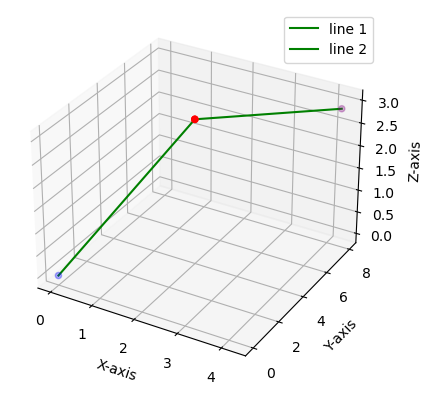

In [7]:
# Tut 1.9.6-7

# create the figure and axes objects
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# define the coordinates of the two points
x = np.array([0, 2])
y = np.array([0, 4])
z = np.array([0, 3])

x1 = np.array([2, 4.23])
y1 = np.array([4, 8])
z1 = np.array([3, 2.87])
# plot the two points
ax.scatter(x, y, z, color=['blue', 'red'])
ax.scatter(x1, y1, z1, color=['red', 'purple'])

# plot the line between the two points
ax.plot(x, y, z, color='green', label='line 1')
ax.plot(x1, y1, z1, color='green', label='line 2')

# set the labels for the axes and the legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend()

# show the plot
plt.show()

### Tut 2.6.1

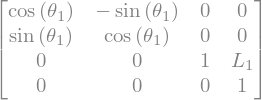

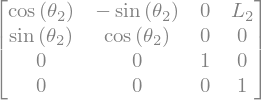

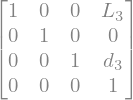

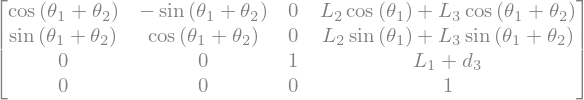

'The position of the end effector'

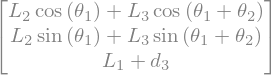

In [194]:
# Tut 2.6.1

DH1 = [0, 0, symbols('L1'), symbols('theta1')]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [symbols('L2'), 0, 0, symbols('theta2')]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [symbols('L3'), 0, symbols('d3'), 0]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

symprint('T',0, 3)
T03 = simplify(T01*T12*T23)
display(T03)

display('The position of the end effector')
display(Position_finder(T03))

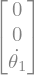

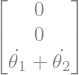

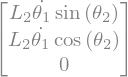

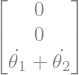

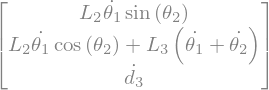

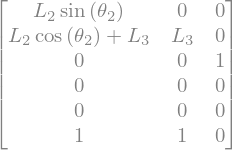

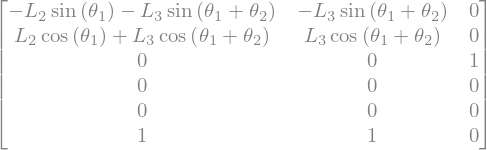

In [197]:
# 4.6.1
 
omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])

# Define speed variables
theta_1_dot = symbols('\dot{\\theta_1}')
theta_2_dot = symbols('\dot{\\theta_2}')
d_3_dot = symbols('\dot{d_3}')

omega_11, v_11 = revolute_joint(frame = 1, theta_dot = theta_1_dot, transform_low_high = T01, omega = omega, v = v)
omega_22, v_22 = revolute_joint(frame = 2, theta_dot = theta_2_dot, transform_low_high = T12, omega = omega_11, v = v_11)
omega_33, v_33 = prismatic_joint(frame = 3, d_dot = d_3_dot, transform_low_high = T23, omega = omega_22, v = v_22)

Jee, J0 = Jacobian(parameters = [theta_1_dot, theta_2_dot, d_3_dot], v_ee = v_33, omega_ee = omega_33, transform_low_high = T03)


### Tut 2.6.2

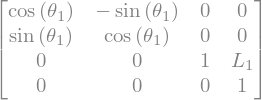

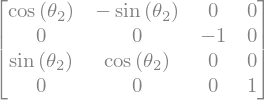

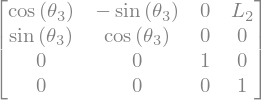

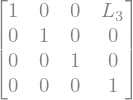

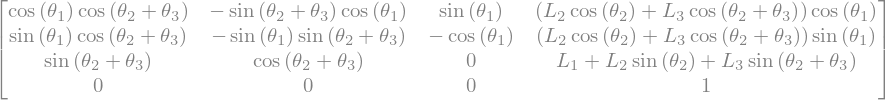

'The position of the end effector'

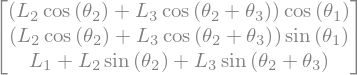

In [198]:
# Tut 2.6.2

DH1 = [0, 0, symbols('L1'), symbols('theta1')]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [0, pi/2, 0, symbols('theta2')]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [symbols('L2'), 0, 0, symbols('theta3')]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

DH4 = [symbols('L3'), 0, 0, 0]
T3E = Tlink(DH4)
symprint('T',3,'E')
display(T3E)

T0E = simplify(T01*T12*T23*T3E)
symprint('T',0, 'E')
display(T0E)

display('The position of the end effector')
display(Position_finder(simplify(T01*T12*T23*T3E)))


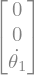

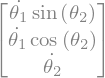

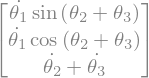

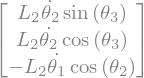

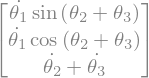

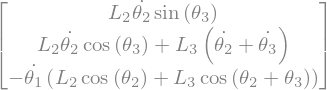

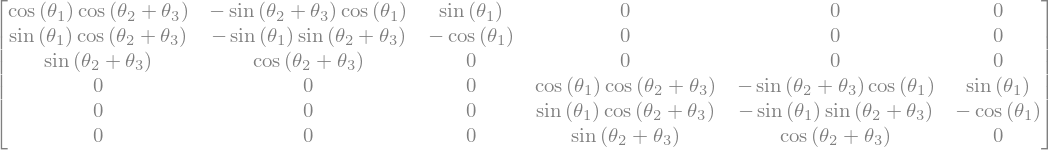

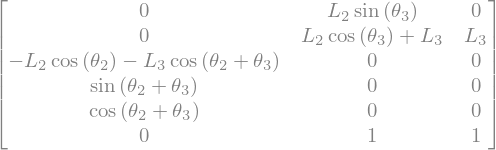

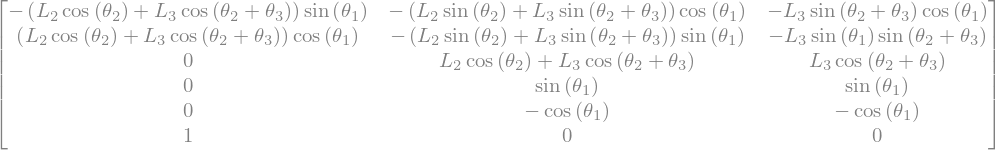

In [199]:
# 4.6.2
 
omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])

theta_1_dot = symbols('\dot{\\theta_1}')
theta_2_dot = symbols('\dot{\\theta_2}')
theta_3_dot = symbols('\dot{\\theta_3}')
theta_e_dot = symbols('\dot{\\theta_e}')

omega_11, v_11 = revolute_joint(frame = 1, theta_dot = theta_1_dot, transform_low_high = T01, omega = omega, v = v)
omega_22, v_22 = revolute_joint(frame = 2, theta_dot = theta_2_dot, transform_low_high = T12, omega = omega_11, v = v_11)
omega_33, v_33 = revolute_joint(frame = 3, theta_dot = theta_3_dot, transform_low_high = T23, omega = omega_22, v = v_22)

# For the end effector
omega_ee, v_ee = revolute_joint(frame = 'e', theta_dot = theta_e_dot, transform_low_high = T3E, omega = omega_33, v = v_33)

# This will work as well
# omega_ee, v_ee = prismatic_joint(frame = 'e', transform_low_high = T3E, omega = omega_33, v = v_33)

Jee, J0 = Jacobian(parameters = [theta_1_dot, theta_2_dot, theta_3_dot], v_ee = v_ee, omega_ee = omega_ee, transform_low_high = T0E, Display_all_details = True)


### Tut 2.6.3

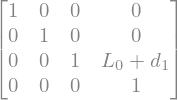

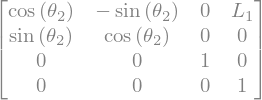

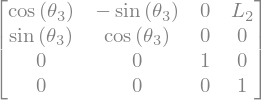

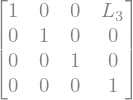

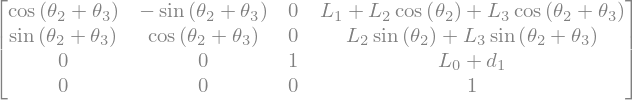

'The position of the end effector'

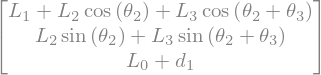

In [200]:
# Tut 2.6.3

DH1 = [0, 0, symbols('d1')+symbols('L0'), 0]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [symbols('L1'), 0, 0, symbols('theta2')]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [symbols('L2'), 0, 0, symbols('theta3')]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

DHE = [symbols('L3'), 0, 0, 0]
T3E = Tlink(DHE)
symprint('T',3, 'E')
display(T3E)

symprint('T',0, 'E')
T0E = T01*T12*T23*T3E 
display(simplify(T0E))

display('The position of the end effector')
display(Position_finder(simplify(T01*T12*T23*T3E)))


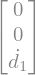

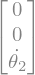

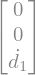

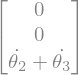

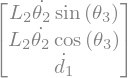

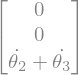

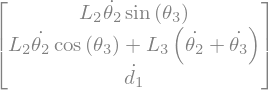

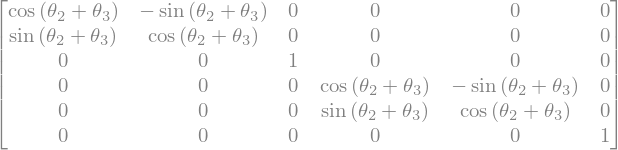

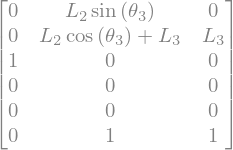

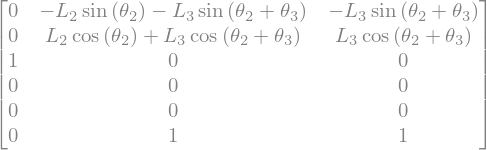

In [204]:
# 4.6.3

omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])

d_1_dot = symbols('\dot{d_1}')
theta_2_dot = symbols('\dot{\\theta_2}')
theta_3_dot = symbols('\dot{\\theta_3}')
theta_e_dot = symbols('\dot{\\theta_e}')

omega_11, v_11 = prismatic_joint(frame = 1, d_dot = d_1_dot, transform_low_high = T01, omega = omega, v = v)
omega_22, v_22 = revolute_joint(frame = 2, theta_dot = theta_2_dot, transform_low_high = T12, omega = omega_11, v = v_11)
omega_33, v_33 = revolute_joint(frame = 3, theta_dot = theta_3_dot, transform_low_high = T23, omega = omega_22, v = v_22)

# For the end effector
omega_ee, v_ee = revolute_joint(frame = 'e', theta_dot = theta_e_dot, transform_low_high = T3E, omega = omega_33, v = v_33)

# This will work as well
# omega_ee, v_ee = prismatic_joint(frame = 'e', transform_low_high = T3E, omega = omega_33, v = v_33)

Jee, J0 = Jacobian(parameters = [d_1_dot, theta_2_dot, theta_3_dot], 
                   v_ee = v_ee, omega_ee = omega_ee, 
                   transform_low_high = T0E, 
                   Display_all_details = True)

### 2.6.4

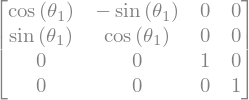

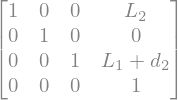

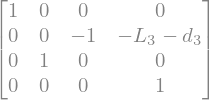

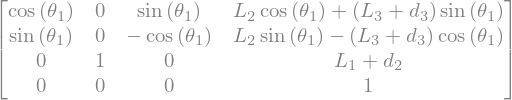

'The position of the end effector'

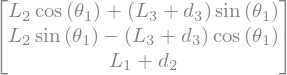

In [206]:
# Tut 2.6.4

DH1 = [0, 0, 0, symbols('theta1')]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [symbols('L2'), 0, symbols('L1') + symbols('d2'), 0]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [0, pi/2, symbols('L3') + symbols('d3'), 0]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

T03 = simplify(T01*T12*T23)
symprint('T',0, '3')
display(T03)

display('The position of the end effector')
display(Position_finder(simplify(T01*T12*T23)))


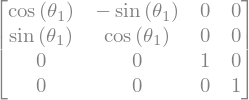

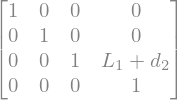

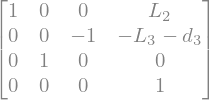

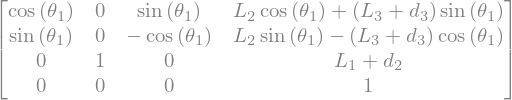

'The position of the end effector'

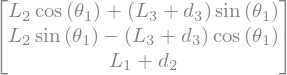

In [207]:
# Tut 2.6.4 sample answer

DH1 = [0, 0, 0, symbols('theta1')]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [0, 0, symbols('L1') + symbols('d2'), 0]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [symbols('L2'), pi/2, symbols('L3') + symbols('d3'), 0]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

symprint('T',0, '3')
T03 = simplify(T01*T12*T23)
display(T03)

display('The position of the end effector')
display(Position_finder(simplify(T01*T12*T23)))

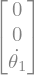

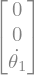

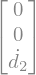

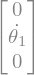

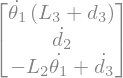

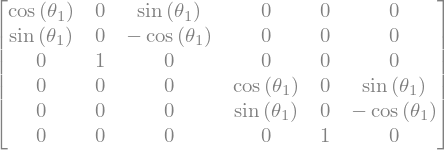

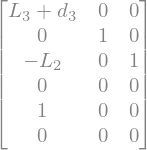

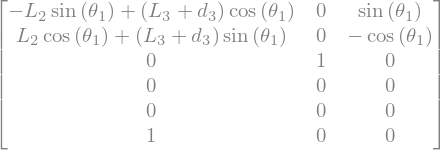

In [208]:
# 4.6.4 (follow the sample solution in the previous questions)

omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])


theta_1_dot = symbols('\dot{\\theta_1}')
d_2_dot = symbols('\dot{d_2}')
d_3_dot = symbols('\dot{d_3}')

omega_11, v_11 = revolute_joint(frame = 1, theta_dot = theta_1_dot, transform_low_high = T01, omega = omega, v = v)
omega_22, v_22 = prismatic_joint(frame = 2, d_dot = d_2_dot, transform_low_high = T12, omega = omega_11, v = v_11)
omega_33, v_33 = prismatic_joint(frame = 3, d_dot = d_3_dot, transform_low_high = T23, omega = omega_22, v = v_22)

Jee, J0 = Jacobian(parameters = [theta_1_dot, d_2_dot, d_3_dot], 
                   v_ee = v_33, omega_ee = omega_33, 
                   transform_low_high = T03, 
                   Display_all_details = True)


### Tut 2.6.5

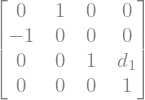

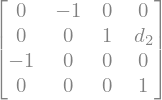

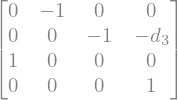

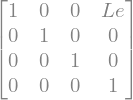

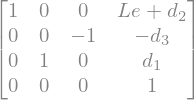

'The position of the end effector'

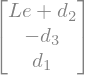

In [209]:
# Tut 2.6.5 sample solution

DH1 = [0, 0, symbols('d1'), -pi/2]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [0, -pi/2, symbols('d2'), pi/2]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [0, pi/2, symbols('d3'), pi/2]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

DHE = [symbols('Le'), 0, 0, 0]
T3E = Tlink(DHE)
symprint('T',3, 'E')
display(T3E)

T0E = T01*T12*T23*T3E
symprint('T',0, 'E')
display(simplify(T0E))

display('The position of the end effector')
display(Position_finder(simplify(T01*T12*T23*T3E)))

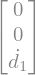

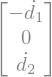

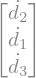

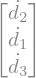

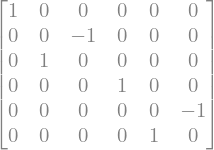

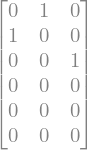

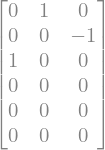

In [210]:
# 4.6.5 

omega = Matrix([0, 0, 0])
v = Matrix([0, 0, 0])


d_1_dot = symbols('\dot{d_1}')
d_2_dot = symbols('\dot{d_2}')
d_3_dot = symbols('\dot{d_3}')
d_e_dot = symbols('\dot{d_e}')


omega_11, v_11 = prismatic_joint(frame = 1, d_dot = d_1_dot, transform_low_high = T01, omega = omega, v = v)
omega_22, v_22 = prismatic_joint(frame = 2, d_dot = d_2_dot, transform_low_high = T12, omega = omega_11, v = v_11)
omega_33, v_33 = prismatic_joint(frame = 3, d_dot = d_3_dot, transform_low_high = T23, omega = omega_22, v = v_22)
omega_ee, v_ee = prismatic_joint(frame = 'e', d_dot = d_e_dot, transform_low_high = T3E, omega = omega_33, v = v_33)

Jee, J0 = Jacobian(parameters = [d_1_dot, d_2_dot, d_3_dot], 
                   v_ee = v_ee, omega_ee = omega_ee, 
                   transform_low_high = T0E, 
                   Display_all_details = True)

### Tut 5.7.1

## Backup script (Not very useful)

In [ ]:
# This method is quite messy
import plotly.graph_objs as go

# define the coordinates of the two points
x = [0, 2]
y = [0, 4]
z = [0, 3]

# create the trace for the points
trace_points = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=['blue', 'red'],
        size=10,
        symbol='circle'
    ),
    name='Point'
)

# create the trace for the line
trace_line = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='lines',
    line=dict(
        color='green',
        width=4
    ),
    name='Line'
)

# create the layout and add the legend
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis')
    ),
    legend=dict(
        x=0.05,
        y=0.95,
        bgcolor='white',
        bordercolor='gray',
        borderwidth=1
    )
)

# create the figure and add the traces and layout
fig = go.Figure(data=[trace_points, trace_line], layout=layout)

# show the plot
fig.show()

In [ ]:
# define the coordinates of the two points for the new line
x_new = [2, 4.23]
y_new = [4, 8]
z_new = [3, 2.87]

# create the trace for the points
trace_points = go.Scatter3d(
    x=x_new,
    y=y_new,
    z=z_new,
    mode='markers',
    marker=dict(
        color=['red', 'green'],
        size=10,
        symbol='circle'
    ),
    name='Point 2'
)

# create the trace for the new line
trace_new_line = go.Scatter3d(
    x=x_new,
    y=y_new,
    z=z_new,
    mode='lines',
    line=dict(
        color='purple',
        width=4
    ),
    name='New Line'
)

# add the new trace to the existing figure object
fig.add_trace(trace_new_line)

# show the plot with the new line added
fig.show()

In [ ]:
def symbol_name(name):
    import re
    name = 'T1'
    if len(re.findall('T', name))!=0:
        name = re.sub('T','theta', name)
        
    raw_str = rf'{name}'
    return raw_str



In [ ]:
symbols('alpha1')

In [ ]:
import re
name = 'T1'
if len(re.findall('T', name))!=0:
    re.sub('T','\theta_', name)

In [ ]:
a11, a12, a13, a21, a22, a23, a31, a32, a33 = symbols('a11 a12 a13 a21 a22 a23 a31 a32 a33')

# Define the matrix
A = Matrix([[cos(a11), a12, a13],
            [a21, a22, a23],
            [a31, a32, a33]])

A.subs(a11, pi)

In [ ]:
a11, a12, a13, a14, a21, a22, a23, a24, a31, a32, a33, a34, a41, a42, a43, a44 = symbols('a11, a12, a13, a14, a21, a22, a23, a24, a31, a32, a33, a34, a41, a42, a43, a44')
T = Matrix([[a11, a12, a13, a14],
            [a21, a22, a23, a24],
            [a31, a32, a33, a34],
            [a41, a42, a43, a44]])

T[0,0]